# Solving the Lane-Emden Relation:

##   $\frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\theta}{d\xi} \right) + \theta^n = 0$

### Here we solve for a fixed polytropic index

In [1]:
import numpy as np
import os, re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as nn_utils
import torch.nn.init as init
import matplotlib.pyplot as plt

from torch.utils import data
from torch.func import functional_call, vmap, grad
from tqdm.notebook import trange, tqdm

DTYPE = torch.float64

torch.set_default_dtype(torch.float64)

# On-the-fly generation of Lane-Emden solutions. Sourced from https://github.com/earlbellinger/Lane-Emden

## NOTE: The manually integrated solutions are NOT used in training the PINN for this exercise.

In [2]:
class LaneEmdenGenerator(data.Dataset):
    def __init__(self, log_delta_xi=-2, max_n = 5, batch_size = 10, seed = 1234,
                 generations_per_epoch = 128, device = 'cuda'):

        self.log_delta_xi = log_delta_xi
        self.max_n = max_n
        self.numpy_rng = np.random.default_rng(seed)
        self.batch_size = batch_size
        self.device = device
        self.generations_per_epoch = 128

    def __getitem__(self, index):
        gen = self.solveLaneEmden(self.log_delta_xi, self.max_n)

        xisvec, ycsvec, ennevec = [], [], []
        xisvec_end, ycsvec_end, ennevec_end = [], [], []

        ## save the last non-nan value, if this goes to zero we know that theta intersect the x-axis and we make it a BC

        for enne in np.random.uniform(3, self.max_n, size=self.batch_size):
            xis, _, ycs = self.solveLaneEmden(self.log_delta_xi, enne)
            xis, ycs = np.array(xis), np.array(np.real(ycs))

            xisvec.append(xis)
            ycsvec.append(np.real(ycs))
            ennevec.append(np.ones_like(xis)*enne)

            xis_out_bc = xis[~np.isnan(ycs)][-1]
            ycs_out_bc = np.real(ycs)[~np.isnan(ycs)][-1]
            if xis_out_bc < 9.999:
                xisvec_end.append(xis_out_bc)
                ycsvec_end.append(ycs_out_bc)
                ennevec_end.append(enne)

        tuple_set = np.vstack(( np.concatenate(ennevec), np.concatenate(ycsvec), np.concatenate(xisvec) )).T
        tuple_set = tuple_set[~np.isnan(tuple_set[:,1])] # take only positive solutions

        tuple_set_outbc = np.vstack(( np.array(ennevec_end), np.zeros(len(xisvec_end)), np.array(xisvec_end) )).T

        return torch.tensor(tuple_set, dtype=DTYPE).to(self.device), torch.tensor(tuple_set_outbc, dtype=DTYPE).to(self.device)

    def __len__(self):
        return self.generations_per_epoch

    def solveLaneEmden(self, log_delta_xi, n):

        delta_xi = 10**log_delta_xi

        # Inner boundary condition
        y0 = 1 - delta_xi**2/6
        z0 = -delta_xi**3/3

        ys  = [y0]
        zs  = [z0]
        xis = [delta_xi]
        ycs = [y0]
        zcs = [z0]
        
        while True:
            y  =  ys[len(ys)  - 1]
            z  =  zs[len(zs)  - 1]
            xi = xis[len(xis) - 1]
            yc = ycs[len(ycs) - 1]
            zc = zcs[len(zcs) - 1]

            ## Primitive method
            yi = y + delta_xi * z/xi**2
            zi = z + delta_xi * -xi**2*y**n

            ## Predictor-corrector technique
            xii = xi + delta_xi
            yci = yc + 1/2 * delta_xi * (z/xi**2 + zi/xii**2)
            zci = zc + 1/2 * delta_xi * (-xi**2*y**n - xi**2*yi**n)
            
            # Outer boundary condition
    #         if (yi < 1e-10 or yci < 1e-10): break
    #         print(yci)
            if xii > 10: break

            xis += [xii]
            ys  += [yi]
            zs  += [zi]
            ycs += [yci]
            zcs += [zci]

        return (xis, ys, ycs)

## Define neural network model

In [3]:
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.SiLU()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            linear_layer = nn.Linear(layers[i], layers[i + 1])
            init.xavier_uniform_(linear_layer.weight) # Glorot Uniform initialization
            init.constant_(linear_layer.bias, 0.0)
            self.layers.append(linear_layer)
        self.activation = activation

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = self.activation(x)
        return self.layers[-1](x)


class NN_Model(nn.Module):
    def __init__(self, branch_layers, trunk_layers, log_delta_xi=-2, device='cuda'):
        super(NN_Model, self).__init__()
        self.branch_net = MLP(branch_layers, activation=nn.SiLU()).to(device)
        self.trunk_net = MLP(trunk_layers, activation=nn.SiLU()).to(device)
        self.log_delta_xi = log_delta_xi
        self.device = device

        self.optimizer = optim.AdamW(self.parameters(), lr=5e-4)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=1-1.25e-5)

        self.loss_log = []
        self.loss_operator_log = []
        self.loss_physics_log = []

    def forward(self, u, y, single=False):
        if single:
            u = u.unsqueeze(0)
            y = y.unsqueeze(0)
        B = self.branch_net(u)
        T = self.trunk_net(y)
        if single:
            outputs = torch.dot(B.squeeze(), T.squeeze())
        else:
            outputs = torch.sum(B * T, dim=1, keepdim=True)
        return outputs

    def compute_sample_ode_loss(self, n, ξ):
        ### Computes the residual of the equation ###
        ### NOTE: The derivatives MUST be one-liners ###
        ### Otherwise it is interpreted as a scalar whose derivative is zero ###
        
        pred = self.forward(n, ξ, True)
        ddξ_ξ2_dθdξ = grad(lambda ξ: (ξ ** 2 * grad(self.forward, argnums=1)(n, ξ, True)).squeeze(), argnums=0)(ξ)

        ξ2_θn = - ( (ξ ** 2) * (pred ** n )  )

        residual = ddξ_ξ2_dθdξ - ξ2_θn

        return residual

    def compute_sample_innergrad_loss(self, u, xi):
        ### dθdξ(ξ=0) = 0 ###
        pred = self.forward(u, xi, True)
        return grad(self.forward, argnums=1)(u, xi, True)

    def compute_sample_innerbc_loss(self, u, xi):
        ### θ(ξ=0) = 1 ###
        pred_at_boundary = self.forward(u, torch.zeros_like(xi), True)
        return pred_at_boundary

    def compute_ode_loss(self, u, xi):
        u = u.clone().detach().requires_grad_(True)
        xi = xi.clone().detach().requires_grad_(True)
        residuals = vmap(self.compute_sample_ode_loss)(u, xi)
        return F.l1_loss(residuals, torch.zeros_like(residuals))

    def compute_inner_bc_loss(self, u, xi):
        u = u.clone().detach().requires_grad_(True)
        xi = xi.clone().detach().requires_grad_(True)
        inner_bc_pred = vmap(self.compute_sample_innerbc_loss)(u, xi)
        return  F.mse_loss(inner_bc_pred, torch.ones_like(inner_bc_pred))

    def compute_inner_grad_loss(self, u, xi):
        u = u.clone().detach().requires_grad_(True)
        xi = xi.clone().detach().requires_grad_(True)*0.
        inner_grad = vmap(self.compute_sample_innergrad_loss)(u, xi)
        return  F.l1_loss(inner_grad, torch.zeros_like(inner_grad))


    def training_step(self, u, y):
        self.optimizer.zero_grad()
        boundary_loss, deriv_loss = 0, 0

        ode_loss = self.compute_ode_loss(u, y)
        deriv_loss = self.compute_inner_grad_loss(u, y)
        boundary_loss = self.compute_inner_bc_loss(u, y)

        total_loss = ode_loss + 1e4*boundary_loss + 1e4*deriv_loss  # weighting BC by an arbitrary factor
        total_loss.backward()

        self.optimizer.step()
        self.scheduler.step()
        return ode_loss.item(), boundary_loss.item(), deriv_loss.item()

    def visualize_example(self, operator_dataloader, iteration,  n=3):
        xisvec, ycsvec, ennevec = [], [], []

        xis, _, ycs = operator_dataloader.solveLaneEmden(self.log_delta_xi, n)

        xis, ycs = np.array(xis), np.array(np.real(ycs))

        xisvec.append(xis)
        ycsvec.append(np.real(ycs))
        ennevec.append(np.ones_like(xis)*n)

        tuple_set = np.vstack(( np.concatenate(ennevec), np.concatenate(ycsvec), np.concatenate(xisvec) )).T
        tuple_set = tuple_set[~np.isnan(tuple_set[:,1])]
        tuple_set_tensor = torch.tensor(tuple_set, dtype=DTYPE).to(self.device)

        with torch.no_grad():
            fig = plt.figure(figsize=(5,5))
            fs = 10
            pred = self.forward(tuple_set_tensor[:,0].unsqueeze(-1), tuple_set_tensor[:,2].unsqueeze(-1) )
            plt.plot(tuple_set[:,2], tuple_set[:,1], label='Manual')
            plt.plot(tuple_set_tensor[:,2].data.cpu().numpy(), pred[:].data.cpu().numpy(), c='r', label='PINN')
            plt.title(f'n: {n}, Iteration: {iteration}', fontsize=fs)
            plt.axhline(y=0, c='k', ls='--')
            plt.text(x=0.65, y= 0.75, fontsize=fs,
                     s= 'Lane-Emden Eqn.\n'+r"$\frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\theta}{d\xi} \right) + \theta^n = 0$" , transform=plt.gca().transAxes)
            plt.legend(loc='upper right')
            plt.xlabel('ξ', fontsize=fs)
            plt.ylabel('θ', fontsize=fs)
            plt.ylim(-0.1, 1.1)
            plt.tick_params(axis='both', which='major', labelsize=fs)
            plt.show()
            plt.close()


    def train(self, operator_dataloader, nIter = 100):
        for i in range(nIter): #nIter is epoch
            boundary_loss_vec = []
            derivative_loss_vec = []
            ode_loss_vec = []

            print(f'Iteration {i}')
            pbar = trange(len(operator_dataloader))
            for _, usy_batch in zip(pbar, operator_dataloader):

                u_batch, _, y_batch = usy_batch[0][:,0].unsqueeze(-1),\
                _, usy_batch[0][:,2].unsqueeze(-1)

                ode_loss_value, boundary_loss_value, derivative_loss_value = self.training_step(u_batch, y_batch)

                pbar.set_postfix({'Boundary Loss': boundary_loss_value,
                                  'Derivative Loss': derivative_loss_value,
                                  'ODE Loss': ode_loss_value,
                                 'learning rate': self.optimizer.param_groups[0]['lr']})

                boundary_loss_vec.append(boundary_loss_value)
                derivative_loss_vec.append(derivative_loss_value)
                ode_loss_vec.append(ode_loss_value)

            print(f'Average ODE Loss: {np.mean(ode_loss_vec)}\nAverage Boundary Loss: {np.mean(boundary_loss_vec)}\n\
            Average Derivative Loss: {np.mean(derivative_loss_vec)},\n\
                  Average Total Loss: {np.mean(ode_loss_vec) +np.mean(boundary_loss_vec) + np.mean(derivative_loss_vec)}')
            pbar.close()

            self.visualize_example(operator_dataloader, i)

## Initialize model


In [4]:
m = 1
ctx = 1
log_delta_xi = -2

num_neurons = 32
num_layers = 8
device = 'cuda'

branch_layers = [m] + [num_neurons] * num_layers
trunk_layers = [ctx] + [num_neurons] * num_layers
gg = LaneEmdenGenerator(log_delta_xi=log_delta_xi, max_n = 3)

model = NN_Model(branch_layers, trunk_layers, log_delta_xi=log_delta_xi, device = device)

## Perform model training. About 3000 iterations is sufficient.


Iteration 0


  0%|          | 0/128 [00:00<?, ?it/s]

Average ODE Loss: 11.014452612500751
Average Boundary Loss: 0.24231461223789286
            Average Derivative Loss: 0.001163300713991038,
                  Average Total Loss: 11.257930525452634


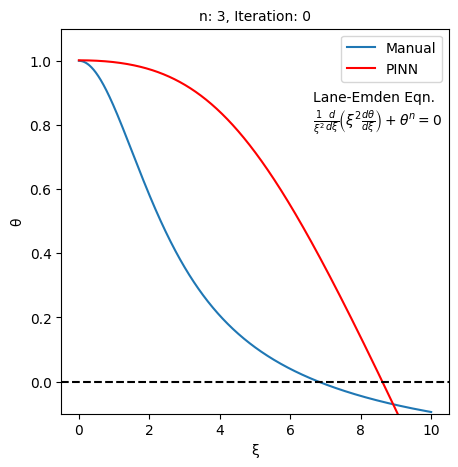

Iteration 1


  0%|          | 0/128 [00:00<?, ?it/s]

Average ODE Loss: 3.727027931528977
Average Boundary Loss: 1.8426899154954345e-06
            Average Derivative Loss: 0.0007068005476348317,
                  Average Total Loss: 3.7277365747665274


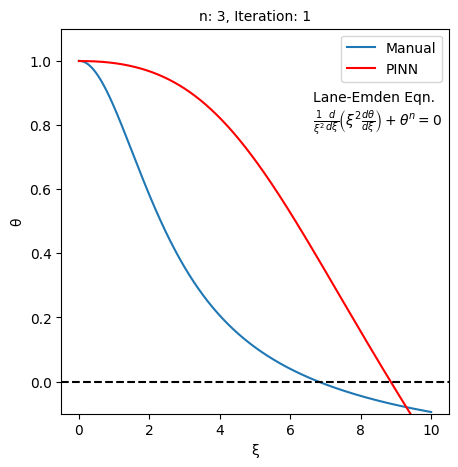

Iteration 2


  0%|          | 0/128 [00:00<?, ?it/s]

Average ODE Loss: 2.933593199691078
Average Boundary Loss: 7.193725045965685e-07
            Average Derivative Loss: 0.0006276771327397414,
                  Average Total Loss: 2.9342215961963225


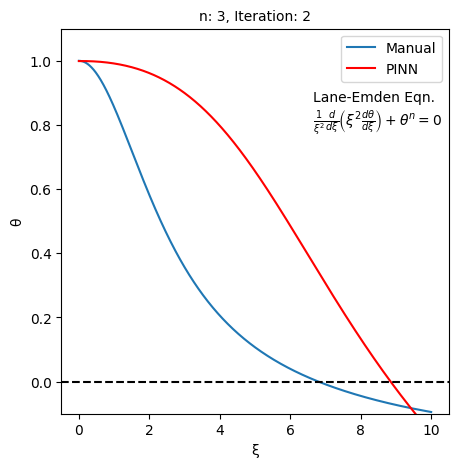

Iteration 3


  0%|          | 0/128 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3f922ce8e0>>
Traceback (most recent call last):
  File "/home/marc/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [5]:
model.train(gg, nIter = 5000)